In [50]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import shutil
from IPython import display

import meep as mp

import sys
sys.path.append('../../lib')
from ataitmeep import *

from lightlab.util import io
from lightlab.util.data import Spectrum, FunctionBundle, MeasuredFunction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
io.dataHome /= 'couplers'
io.pprintFileDir()

                   couplers ** directory
                 reflectors ** directory
  bullseye_dutysweep.pkl.gz    io.loadPickleGzip('bullseye_dutysweep.pkl')
     bullseye_period.pkl.gz    io.loadPickleGzip('bullseye_period.pkl')
bullseye_pointsource.pkl.gz    io.loadPickleGzip('bullseye_pointsource.pkl')
  extraction_efficiency.pdf   
             out_gap.pkl.gz    io.loadPickleGzip('out_gap.pkl')
       shovel-length.pkl.gz    io.loadPickleGzip('shovel-length.pkl')


[PosixPath('/Users/ant12/Documents/git-projects/sim-code/atait-meep/data/bullseye_dutysweep.pkl.gz'),
 PosixPath('/Users/ant12/Documents/git-projects/sim-code/atait-meep/data/bullseye_period.pkl.gz'),
 PosixPath('/Users/ant12/Documents/git-projects/sim-code/atait-meep/data/bullseye_pointsource.pkl.gz'),
 PosixPath('/Users/ant12/Documents/git-projects/sim-code/atait-meep/data/extraction_efficiency.pdf'),
 PosixPath('/Users/ant12/Documents/git-projects/sim-code/atait-meep/data/out_gap.pkl.gz'),
 PosixPath('/Users/ant12/Documents/git-projects/sim-code/atait-meep/data/shovel-length.pkl.gz')]

In [132]:
# Define the system
# parameters for 1220nm

default_geometry = dict(
                        device_height = 0.22,
                        pitch = .544,  # .544 for Ez
                        duty = .45,
                        post_diameter = .5,
                        n_periods = 10,
                        box_height = 2,
                        cladding_height = 2,
                        handle_height = 3,
                        source_diameter = .1
                       )

oxide = mp.Medium(epsilon=2.25)
silicon = mp.Medium(epsilon=12)
air = mp.Medium(epsilon=1)

def give_cell(**kwargs):
    geom_dict = default_geometry.copy()
    geom_dict.update(kwargs)
    geo = objview(**geom_dict)

    cell = mp.Vector3(2 * geo.pitch * geo.n_periods + 5, geo.box_height + geo.cladding_height + 2*geo.handle_height)
    return cell

def give_geometry(**kwargs):
    geom_dict = default_geometry.copy()
    geom_dict.update(kwargs)
    geo = objview(**geom_dict)
    
    cladding = mp.Block(mp.Vector3(cell.x, geo.box_height + geo.cladding_height, 1e20),
                        center=mp.Vector3(0, 0),
                        material=oxide)
    handle = mp.Block(mp.Vector3(cell.x, geo.handle_height, 1e20),
                     center=mp.Vector3(0, -cell.y/2 + geo.handle_height/2),
                     material=silicon)
    space = mp.Block(mp.Vector3(cell.x, geo.handle_height, 1e20),
                     center=mp.Vector3(0, cell.y/2 - geo.handle_height/2),
                     material=air)
    device_layer = [mp.Block(mp.Vector3(geo.post_diameter, geo.device_height, 1e20),
                                        center=mp.Vector3(0, 0),
                                        material=silicon),
                   ]
    for iPeriod in range(geo.n_periods):
        for side_sign in [-1, 1]:
            device_layer.append(mp.Block(mp.Vector3(geo.pitch * geo.duty, geo.device_height, 1e20),
                                         center=mp.Vector3(side_sign * (geo.pitch * iPeriod + geo.pitch*1)),
                                         material=silicon))
    geometry = [cladding, handle, space]
    geometry.extend(device_layer)
    return geometry

cell = give_cell()
geometry = give_geometry()
    
dpml = 1.
pml_layers = [mp.PML(dpml)]

# this should be replaced by an eigenmode
fcen = 1 / 1.22
df = fcen / 20
nfreq = 101
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
                     component=mp.Ez,
                     center=mp.Vector3(0, 0), 
                     size=mp.Vector3(default_geometry['source_diameter'], 0*default_geometry['device_height']),
                    ),
          ]
# sources = [mp.Source(mp.ContinuousSource(frequency=fcen, width=2),
#                      component=mp.Ez,
#                      center=mp.Vector3(0, default_geometry['device_height']/2), 
#                      size=mp.Vector3(default_geometry['source_diameter'], default_geometry['device_height']),
#                     )
#           ]

resolution = 20

def livefield(sim):
    liveplot(sim, sources[0].component)

-----------
Initializing structure...
run 0 finished at t = 0.0 (0 timesteps)


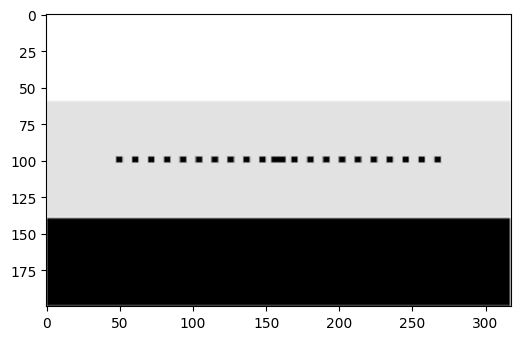

In [133]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
#                     symmetries=[mp.Mirror(mp.Y, phase=-1)],
                    progress_interval=1e6)

eps_data = show_geometry(sim)

KeyboardInterrupt: 

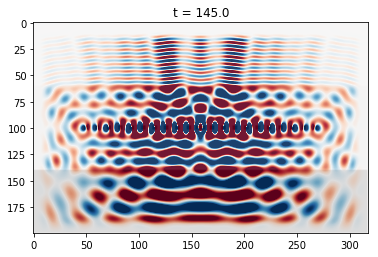

In [159]:
def plot_sim(until=200):
    sim.reset_meep()
    shutil.rmtree('outputs', ignore_errors=True)
    sim.use_output_directory('outputs')
    sim.run(
            mp.at_beginning(livefield),
            mp.at_every(5, livefield),
#             mp.at_every(.05, mp.output_png(sources[0].component, "-Zc dkbluered")),
#             mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
            until=until)
    # now make the gif
#     subprocess.check_call(['convert', 'outputs/ez-*.png', 'ez.gif'])
#     subprocess.check_call(['open', '-a', 'Safari', 'ez.gif'])

plt.figure(figsize=(6,8))
plot_sim(300)

In [148]:
def do_trial(straight_refl_data=None, with_geometry=geometry, do_live=True, baseline=False):
    sim = mp.Simulation(cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=with_geometry if not baseline else give_geometry(duty=0),
                        sources=sources,
                        resolution=resolution,
#                         symmetries=[mp.Mirror(mp.Y, phase=-1)],
#                         progress_interval=1e6,
                       )
    sim.reset_meep()
    # reflected flux
    refl_fr = mp.FluxRegion(center=mp.Vector3(0,cell.y/2-dpml-.2,0), size=mp.Vector3(cell.x,0,0))                            
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    monitor_pt = mp.Vector3(0,0)
    run_args = (mp.at_beginning(livefield), mp.at_every(5, livefield),) if do_live else tuple()
    sim.run(*run_args,
            until_after_sources=mp.stop_when_fields_decayed(50,sources[0].component, monitor_pt,1e-3))
    return refl

KeyboardInterrupt: 

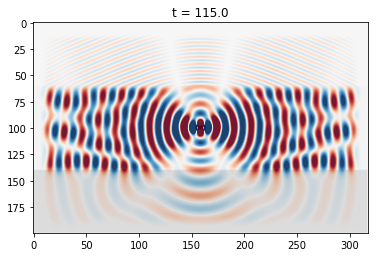

In [160]:
# Do the baseline
refl = do_trial(baseline=True)
bend_refl_flux = np.array(mp.get_fluxes(refl))
flux_freqs = np.array(mp.get_flux_freqs(refl))
wl = 1 / flux_freqs

spct_baseline = Spectrum(wl[::-1], bend_refl_flux[::-1], inDbm=False)

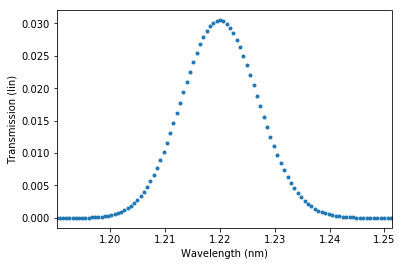

In [150]:
spct_baseline.simplePlot('.')
spct1.db() - spct_baseline.db()

In [151]:
# parameter sweep
isResimulating = True
isSaving = True
filename = 'bullseye_pitchsweep.pkl'

pitch_vals = np.linspace(.54, .55, 6)
duty_vals = np.linspace(0, 1, 21)

if isResimulating:
    param_vals = pitch_vals
    spectra = FunctionBundle()
    for p in param_vals:
        refl = do_trial(with_geometry=give_geometry(pitch=p), 
                        do_live=False)
        bend_refl_flux = np.array(mp.get_fluxes(refl))
        spct1 = Spectrum(wl[::-1], bend_refl_flux[::-1], inDbm=False)
        spct1 = spct1.db() - spct_baseline.db()
        spectra.addDim(spct1.db())
    if isSaving:
        io.savePickleGzip(dataTuple=(param_vals, spectra), filename=filename)
else:
    param_vals, spectra = io.loadPickleGzip(filename=filename)
   

-----------
Initializing structure...
field decay(t = 50.025000000000006): 4.611795458094787e-06 / 4.611795458094787e-06 = 1.0
field decay(t = 100.05000000000001): 0.02583574843733897 / 0.02583574843733897 = 1.0
field decay(t = 150.07500000000002): 0.1701462164225874 / 0.1701462164225874 = 1.0
field decay(t = 200.10000000000002): 0.16870379637748906 / 0.1701462164225874 = 0.991522467702039
field decay(t = 250.125): 0.0870959208644102 / 0.1701462164225874 = 0.5118886725526267
field decay(t = 300.15000000000003): 0.024741912330588627 / 0.1701462164225874 = 0.14541558931371024
field decay(t = 350.175): 0.007636600604410652 / 0.1701462164225874 = 0.044882576674193216
field decay(t = 400.20000000000005): 0.002323307792796009 / 0.1701462164225874 = 0.013654772005189199
field decay(t = 450.225): 0.000712839179810754 / 0.1701462164225874 = 0.004189568212556049
field decay(t = 500.25): 0.00021535744072788418 / 0.1701462164225874 = 0.0012657198335401531
field decay(t = 550.275): 6.61012135984247

Saving to file: /Users/ant12/Documents/git-projects/sim-code/atait-meep/data/extraction_efficiency_sweep.pdf


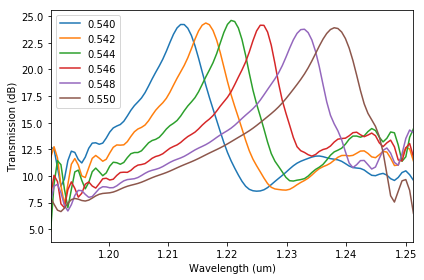

In [152]:
for sl in range(0, len(spectra), 1):
    spectra[sl].simplePlot(label='{:.3f}'.format(param_vals[sl]))
plt.xlabel('Wavelength (um)')
io.saveFigure('extraction_efficiency_sweep')